In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
from collections import Counter
from bs4 import BeautifulSoup
import matplotlib
import math
import matplotlib.pyplot as plt
from contractions import contractions_dict
import re
import seaborn as sns
import unicodedata
import nltk
nltk.download('stopwords')
from nltk.tokenize.toktok import ToktokTokenizer
import spacy
from spacy.lang.en import English
nlp = spacy.load('en_core_web_sm', parse = False, tag = False, entity = False)
import time

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, LogisticRegression

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
POSITIVE = pd.read_csv('/content/dataset/positive.csv', sep=',')
NEGATIVE = pd.read_csv('/content/dataset/negative.csv', sep=',')
rawData = pd.concat([POSITIVE, NEGATIVE],axis=0)
rawData.head(5)

,Review,Label
0,Better than Wolff's Kasha. I grew up eating Ka...,1
1,It was such good product. Came in two differen...,1
2,MMMM Yes all chocolate is good.<br />But some ...,1
3,"This is, as all of their cereals I've ordered ...",1
4,Whoever Photoshopped the cookie on the front o...,1


In [5]:
print("The shape of the dataset is: ", rawData.shape)

The shape of the dataset is:  (50000, 2)


In [6]:
#Shuffling the values in the dataset
rawData.sample(frac=1)

,Review,Label
20599,I have to buy this dog food for my Dashound be...,1
6994,well... it won't kill you. the flavor is good....,0
3633,This is my favorite spicy mustard. After a tr...,0
22501,"I've been using this product for years, but th...",0
22084,I bought the tea for my mother who has asthma....,1
...,...,...
3812,I looked forward to amazing popcorn... Instead...,0
17463,While I did not at any time imagine that I was...,1
7441,Before I get into my commentary about the Orij...,0
541,The item is different from the one that bought...,0


In [7]:
Counter(" ".join(rawData["Review"]).split()).most_common(10)

[('the', 156501),
 ('I', 130866),
 ('and', 107416),
 ('a', 103296),
 ('to', 91397),
 ('of', 74159),
 ('is', 62916),
 ('it', 59766),
 ('this', 46084),
 ('in', 46005)]

In [8]:
rawData.isnull().sum()

Review    0
Label     0
dtype: int64

In [9]:
rawData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  50000 non-null  object
 1   Label   50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [12]:
rawData['Label'].unique()

array([1, 0])

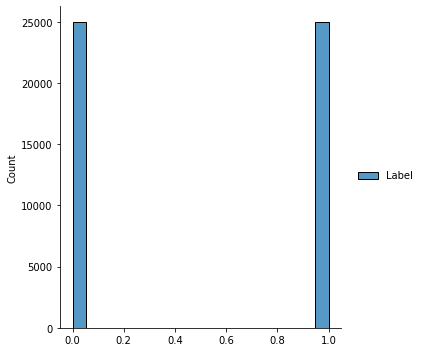

In [13]:
sns.displot(rawData)

In [14]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

In [15]:
print(NEGATIVE['Review'][7])
Testtext = strip_html_tags(NEGATIVE['Review'][7])
print('-'*150)
print(Testtext)

The previous reviewer is totally on point. Watery, not cheesy, very hot.<br /><br />So, the only thing they got right was the "hot." Flavor is horrible, texture is nasty ( not cheesy yumnmy).<br /><br />Skip it, and you won't regret wasting your money the way I did. These went in the trash.<br /><br />Mir
------------------------------------------------------------------------------------------------------------------------------------------------------
The previous reviewer is totally on point. Watery, not cheesy, very hot.So, the only thing they got right was the "hot." Flavor is horrible, texture is nasty ( not cheesy yumnmy).Skip it, and you won't regret wasting your money the way I did. These went in the trash.Mir


In [25]:
def remove_special_characters(text):
    text = re.sub('[^a-zA-z0-9\s]', '', text)
    return text

In [27]:
print(POSITIVE['Review'][337])
Testtext = remove_special_characters(POSITIVE['Review'][337])
print('-'*150)
print(Testtext)

I recently bought the <a href="http://www.amazon.com/gp/product/B000VX7VJO">Breville BKC600XL Gourmet Single-Cup Coffee Brewer</a>, which I love, and found a wide variety of 5 pack K-Cup samplers at Keurig.com.  <a href="http://www.amazon.com/gp/product/B000J4IDP6">Gloria Jean's Coffee, Mudslide, K-Cups for Keurig Brewers, 25-Count Boxes (Pack of 2)</a> was in the Flavored Coffee sampler and there's one word that says how I feel about it - YUM! I used the 9 oz setting, which worked well, and the smell coming out of the brewer was heavenly. It has a very rich chocolate taste that reminded me of brownies and fudge. I added a little Coffee Mate Vanilla creamer and a shot of DeKuyper Butterscotch Schnapps - wow! It was so good I could have drank three of them. Unfortunately there was only one, but there will be more in a few days when the two boxes I ordered arrive!
-----------------------------------------------------------------------------------------------------------------------------

In [28]:
def expand_contractions(text, contraction_mapping=contractions_dict):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)

    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match) if contraction_mapping.get(match) else contraction_mapping.get(match.lower())                               
        return first_char+expanded_contraction[1:] if expanded_contraction != None else match
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [29]:
print(POSITIVE['Review'][342])
Testtext = expand_contractions(POSITIVE['Review'][342])
print('-'*150)
print(Testtext)

I've been eating Nagatanien Ochazuke Nori since I was a little girl.  I'm now 44 years old and still find the product delicious and satisfying!  It is way cheaper to purchase the 30-pack of Ochazuke vs buying it per pack at my local Asian store.  Me/my family use maybe a pack every week or so (each pack contains 3 envelopes).  When my kids have friends over when we happen to serve white rice for dinner with this ochazuke as a topping, the friends initially have a 'yuck' reaction when we tell them it contains seaweed.  However, once they taste it they usually have seconds!
------------------------------------------------------------------------------------------------------------------------------------------------------
I have been eating Nagatanien Ochazuke Nori since I was a little girl.  I am now 44 years old and still find the product delicious and satisfying!  It is way cheaper to purchase the 30-pack of Ochazuke vs buying it per pack at my local Asian store.  Me/my family use may

In [30]:
def lemmatize_text(text):
    text = nlp(text)
    return ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])

In [31]:
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

def remove_stopwords(text, is_lower_case=False):
    tokenizer = ToktokTokenizer()
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text


In [32]:
print(POSITIVE['Review'][328])
Testtext = remove_stopwords(POSITIVE['Review'][328])
print('-'*150)
print(Testtext)

I haven't used the honey in my granola yet which is why I purchased in the first place.  I did taste and try it in my spaghetti sauce and felt that it tasted very good.  The one thing is that it has a very strong honey taste which makes it have that pure taste to me.  My store bought honey was good but until I tried the Tropic Bee did I realize the difference was in the strength of the honey taste.  It's mild as far as not having that after taste of foods that are stronger in intensity from being a pure source of whatever it was taken from.  A good buy as far as I can tell.  I can't wait to make my granola bars to see if I get a sweeter taste than what I was getting with my store bought honey.
------------------------------------------------------------------------------------------------------------------------------------------------------
' used honey granola yet purchased first place. taste try spaghetti sauce felt tasted good. one thing strong honey taste makes pure taste me. stor

In [33]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # insert spaces between special characters to isolate them    
        special_char_pattern = re.compile(r'([{.(-)!}])')
        doc = special_char_pattern.sub(" \\1 ", doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters    
        if special_char_removal:
            doc = remove_special_characters(doc)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
    return normalized_corpus

In [34]:
#rawData['Review'] = normalize_corpus(rawData.Review)
#rawData.to_csv("normalized_food_reviews.csv", index = False)

In [35]:
normalized_food_reviews = pd.read_csv('/content/normalized_food_reviews.csv')
normalized_food_reviews.head(5)

,Review,Label
0,well wolff kasha grow eat kasha easy prepare h...,1
1,good product come two different box describe c...,1
2,mmmm yes chocolate good chocolate well well ch...,1
3,cereal order far fresh high quality wonderful ...,1
4,whoever photoshoppe cookie front package true ...,1


In [36]:
normalized_food_reviews = pd.read_csv("/content/normalized_food_reviews.csv")
numberOfReviews=35000
reviews = np.array(normalized_food_reviews['Review'].iloc[:numberOfReviews])
Label = np.array(normalized_food_reviews['Label'].iloc[:numberOfReviews])

# extract data for model evaluation
train_reviews, test_reviews, train_Label, test_Label = train_test_split(reviews, Label, test_size=0.3)

# build BOW features on train reviews
cv = CountVectorizer(binary=False, min_df=0.0, max_df=1.0, ngram_range=(1,2))
cv_train_features = cv.fit_transform(train_reviews)

# build TFIDF features on train reviews
tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0, ngram_range=(1,2),sublinear_tf=True)
tv_train_features = tv.fit_transform(train_reviews)

In [37]:
cv_test_features = cv.transform(test_reviews)
tv_test_features = tv.transform(test_reviews)

In [38]:
print('BOW model:> Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)
print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)

BOW model:> Train features shape: (24500, 477180)  Test features shape: (10500, 477180)
TFIDF model:> Train features shape: (24500, 477180)  Test features shape: (10500, 477180)


In [39]:
# We define our SVM and LR models
lr = LogisticRegression(penalty='l2', max_iter=1000, C=1)
svm = SGDClassifier(loss='hinge', max_iter=100)

In [78]:
# Logistic Regression model on BOW features
lr.fit(cv_train_features, train_Label)
y_predicted = lr.predict(cv_test_features)

print("The model accuracy score is: {}".format(accuracy_score(test_Label, y_predicted)))
print("The model precision score is: {}".format(precision_score(test_Label, y_predicted, average="weighted")))
print("The model recall score is: {}".format(recall_score(test_Label, y_predicted, average="weighted")))
print("The model F1-score is: {}".format(f1_score(test_Label, y_predicted, average="weighted")))

print(classification_report(test_Label, y_predicted))

display(pd.DataFrame(confusion_matrix(test_Label, y_predicted), columns=["Pred. negative", "Pred. positive"], index=["Act. negative", "Act. positive"]))

The model accuracy score is: 0.6666666666666666
The model precision score is: 0.5996828523031845
The model recall score is: 0.6666666666666666
The model F1-score is: 0.6182174293302882
              precision    recall  f1-score   support

           0       0.30      0.13      0.18      2973
           1       0.72      0.88      0.79      7527

    accuracy                           0.67     10500
   macro avg       0.51      0.50      0.49     10500
weighted avg       0.60      0.67      0.62     10500



,Pred. negative,Pred. positive
Act. negative,388,2585
Act. positive,915,6612


In [57]:
# Logistic Regression model on TF-IDF features
lr.fit(cv_train_features, train_Label)
y_predicted = lr.predict(tv_test_features)

print("The model accuracy score is: {}".format(accuracy_score(test_Label, y_predicted)))
print("The model precision score is: {}".format(precision_score(test_Label, y_predicted, average="weighted")))
print("The model recall score is: {}".format(recall_score(test_Label, y_predicted, average="weighted")))
print("The model F1-score is: {}".format(f1_score(test_Label, y_predicted, average="weighted")))

print(classification_report(test_Label, y_predicted))

display(pd.DataFrame(confusion_matrix(test_Label, y_predicted), columns=["Pred. negative", "Pred. positive"], index=["Act. negative", "Act. positive"]))

The model accuracy score is: 0.7168571428571429
The model precision score is: 0.5138841632653062
The model recall score is: 0.7168571428571429
The model F1-score is: 0.5986335734493499
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2973
           1       0.72      1.00      0.84      7527

    accuracy                           0.72     10500
   macro avg       0.36      0.50      0.42     10500
weighted avg       0.51      0.72      0.60     10500



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TypeError: ignored

In [42]:
# SVM model on BOW
svm.fit(cv_train_features,train_Label)
y_predicted = svm.predict(cv_test_features)

print("The model accuracy score is: {}".format(accuracy_score(test_Label, y_predicted)))
print("The model precision score is: {}".format(precision_score(test_Label, y_predicted, average="weighted")))
print("The model recall score is: {}".format(recall_score(test_Label, y_predicted, average="weighted")))
print("The model F1-score is: {}".format(f1_score(test_Label, y_predicted, average="weighted")))

print(classification_report(test_Label, y_predicted))

display(pd.DataFrame(confusion_matrix(test_Label, y_predicted), columns=["Pred. negative", "Pred. positive"], index=["Act. negative", "Act. positive"]))

The model accuracy score is: 0.8635238095238095
The model precision score is: 0.8614576698683353
The model recall score is: 0.8635238095238095
The model F1-score is: 0.8621291425247117
              precision    recall  f1-score   support

           0       0.78      0.73      0.76      3058
           1       0.89      0.92      0.90      7442

    accuracy                           0.86     10500
   macro avg       0.84      0.83      0.83     10500
weighted avg       0.86      0.86      0.86     10500



,Pred. negative,Pred. positive
Act. negative,2242,816
Act. positive,617,6825


In [43]:
#SVM model on TF-IDF
svm.fit(tv_train_features,train_Label)
y_predicted = svm.predict(tv_test_features)

print("The model accuracy score is: {}".format(accuracy_score(test_Label, y_predicted)))
print("The model precision score is: {}".format(precision_score(test_Label, y_predicted, average="weighted")))
print("The model recall score is: {}".format(recall_score(test_Label, y_predicted, average="weighted")))
print("The model F1-score is: {}".format(f1_score(test_Label, y_predicted, average="weighted")))

print(classification_report(test_Label, y_predicted))

display(pd.DataFrame(confusion_matrix(test_Label, y_predicted), columns=["Pred. negative", "Pred. positive"], index=["Act. negative", "Act. positive"]))

The model accuracy score is: 0.8681904761904762
The model precision score is: 0.8678808531033733
The model recall score is: 0.8681904761904762
The model F1-score is: 0.862000289521294
              precision    recall  f1-score   support

           0       0.86      0.65      0.74      3058
           1       0.87      0.96      0.91      7442

    accuracy                           0.87     10500
   macro avg       0.87      0.80      0.83     10500
weighted avg       0.87      0.87      0.86     10500



,Pred. negative,Pred. positive
Act. negative,1984,1074
Act. positive,310,7132


In [44]:
#ML MODELS LIBRARIES

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize.toktok import ToktokTokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, SpatialDropout1D
from tensorflow.keras.layers import LSTM


le = LabelEncoder()
tokenizer = ToktokTokenizer()

normalized_food_reviews = pd.read_csv("/content/normalized_food_reviews.csv")
numberOfReviews=35000
reviews = np.array(normalized_food_reviews['Review'].iloc[:numberOfReviews])
Label = np.array(normalized_food_reviews['Label'].iloc[:numberOfReviews])

# extract data for model evaluation
train_reviews, test_reviews, train_Label, test_Label = train_test_split(reviews, Label, test_size=0.3)


# tokenize reviews
tokenized_train = [tokenizer.tokenize(text) for text in train_reviews]
tokenized_test = [tokenizer.tokenize(text) for text in test_reviews]

#Building word to index vocabulary
token_counter = Counter([token for review in tokenized_train for token in review])
vocab_map = {item[0]: index+1 for index, item in enumerate(dict(token_counter).items())}
max_index = np.max(list(vocab_map.values()))
vocab_map['PAD_INDEX'] = 0
vocab_map['NOT_FOUND_INDEX'] = max_index+1
vocab_size = len(vocab_map)
# view vocabulary size and part of the vocabulary map
print('Vocabulary Size:', vocab_size)
print('Sample slice of vocabulary map:', dict(list(vocab_map.items())[10:20]))

Vocabulary Size: 27300
Sample slice of vocabulary map: {'egg': 11, 'milk': 12, 'butter': 13, 'oil': 14, 'raisin': 15, 'caraway': 16, 'seed': 17, 'orange': 18, 'rind': 19, 'great': 20}


In [45]:
# get max length of train corpus and initialize label encoder
from tensorflow.keras.preprocessing import sequence

le = LabelEncoder()
max_len = np.max([len(review) for review in tokenized_train])

# Convert tokenized text reviews to numeric vectors
train_X = [[vocab_map[token] for token in tokenized_review] for tokenized_review in tokenized_train]
train_X = sequence.pad_sequences(train_X, maxlen=max_len) # pad 
test_X = [[vocab_map[token] if vocab_map.get(token) else vocab_map['NOT_FOUND_INDEX'] 
           for token in tokenized_review] 
              for tokenized_review in tokenized_test]
test_X = sequence.pad_sequences(test_X, maxlen=max_len)

# Convert text sentiments into binary encodings
train_y = le.fit_transform(train_Label)
test_y = le.transform(test_Label)

print('Max length of train review vectors:', max_len)
print('Train review vectors shape:', train_X.shape, ' Test review vectors shape:', test_X.shape)

Max length of train review vectors: 886
Train review vectors shape: (24500, 886)  Test review vectors shape: (10500, 886)


In [46]:
EMBEDDING_DIM = 128 # dimension for dense embeddings for each token
LSTM_DIM = 64 # total LSTM units

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam",metrics=["accuracy"])

In [47]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 886, 128)          3494400   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 886, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 3,543,873
Trainable params: 3,543,873
Non-trainable params: 0
_________________________________________________________________
None


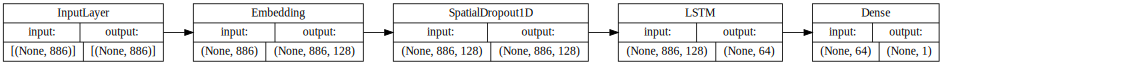

In [48]:
# Plotting librairies
from IPython.display import SVG
SVG(tf.keras.utils.model_to_dot(model, show_shapes=True, show_layer_names=False, rankdir='LR', dpi=60).create(prog='dot', format='svg'))

In [49]:
batch_size = 100
model.fit(train_X, train_y, epochs=3, batch_size=batch_size, shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/3
221/221 [==============================] - 514s 2s/step - loss: 0.5092 - accuracy: 0.7561 - val_loss: 0.3200 - val_accuracy: 0.8649
Epoch 2/3
221/221 [==============================] - 508s 2s/step - loss: 0.2675 - accuracy: 0.8944 - val_loss: 0.3118 - val_accuracy: 0.8727
Epoch 3/3
221/221 [==============================] - 509s 2s/step - loss: 0.2015 - accuracy: 0.9238 - val_loss: 0.3436 - val_accuracy: 0.8641


In [77]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


pred_test = model.predict_classes(test_X)
y_predicted = le.inverse_transform(pred_test.flatten())

print("The model accuracy score is: {}".format(accuracy_score(test_Label, y_predicted)))
print("The model precision score is: {}".format(precision_score(test_Label, y_predicted, average="weighted")))
print("The model recall score is: {}".format(recall_score(test_Label, y_predicted, average="weighted")))
print("The model F1-score is: {}".format(f1_score(test_Label, y_predicted, average="weighted")))

print(classification_report(test_Label, y_predicted))

display(pd.DataFrame(confusion_matrix(test_Label, y_predicted), columns=["Pred. negative", "Pred. positive"], index=["Act. negative", "Act. positive"]))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


The model accuracy score is: 0.8571428571428571
The model precision score is: 0.8537411031113593
The model recall score is: 0.8571428571428571
The model F1-score is: 0.8542802627795957
              precision    recall  f1-score   support

           0       0.78      0.69      0.73      2973
           1       0.88      0.92      0.90      7527

    accuracy                           0.86     10500
   macro avg       0.83      0.81      0.82     10500
weighted avg       0.85      0.86      0.85     10500



,Pred. negative,Pred. positive
Act. negative,2047,926
Act. positive,574,6953


In [74]:
import pickle

In [79]:
pkl_filename = 'SVM_Model.pkl'
with open('svm_pickle', 'wb') as f:
  pickle.dump(svm, f)

In [80]:
with open('svm_pickle', 'rb') as f:
  np = pickle.load(f)
